### Please note that the tabulate module should be version 0.8.10 as dictated in the requirements file, we have noticed that version 0.9.0 causes issues.

In [ ]:
%pip install -r ./requirements_privacy_evaluation.txt

In [1]:
import pandas as pd
from tabulate import tabulate
import math
import numpy as np
DAY_MAP = {0: 'Monday', 1: 'Tuesday', 2: 'Wednesday', 3: 'Thursday', 4: 'Friday', 5: 'Saturday', 6: 'Sunday'}
# Read the POI dataset
pois = pd.read_csv('pois.csv', sep=' ', header=0)
# Read the Queries dataset
queries = pd.read_csv('queries.csv', sep=' ', header=0)

# Preprocessing

In [2]:
# The timestamp in the queries dataset is in hours from the start of the dataset which is the midnight of the sunday connecting to monday
# We'll create a new column called day of the week which will be the day of the week of the timestamp
queries['day_of_week'] = queries['timestamp'].apply(lambda x: (x // 24) % 7)
# We map the number to the string representation of the day of the week
# queries['day_of_week'] = queries['day_of_week'].map(DAY_MAP)
# Now we create a new column called hour of day which will be the hour of the day of the timestamp
queries['hour_of_day'] = queries['timestamp'].apply(lambda x: math.floor(x % 24))
# Finally we create a day column to be the day number, i.e. the number of days since the start of the dataset
queries['day'] = queries['timestamp'].apply(lambda x: x // 24)

In [3]:
queries.poi_type_query.value_counts()

restaurant     5218
cafeteria      5131
club           2145
gym            2063
bar            2051
supermarket    2001
dojo           1834
Name: poi_type_query, dtype: int64

In [4]:
pois.poi_type.value_counts()

dojo                135
bar                 114
cafeteria           114
restaurant          112
appartment_block    112
club                110
supermarket         108
gym                 107
villa                88
laboratory           26
company              19
office               15
Name: poi_type, dtype: int64

In [5]:
pois.head()

,poi_id,cell_id,poi_type,lat,lon
0,307,1,bar,46.504486,6.559631
1,331,1,bar,46.500259,6.554721
2,578,1,supermarket,46.506017,6.551165
3,897,1,club,46.504494,6.553889
4,972,1,supermarket,46.502984,6.550519


In [8]:
# Now we want to assess the privacy leakage of the queries dataset
# We assume that each ip_address maps to a unique user
# We group the POIs into these categories
POI_MAPS = {
    "villa": "home",
    "appartment_block": "home",
    "restaurant": "meal",
    "cafeteria": "meal",
    "laboratory": "work",
    "company": "work",
    "office": "work",
    "supermarket": "shopping",
    "dojo": "hobby",
    "gym": "hobby",
    "bar": "entertainment",
    "club": "entertainment"
}
# Save the original poi_type column
pois['poi_type_original'] = pois['poi_type']
# Save the original poi_type_query column
queries['poi_type_query_original'] = queries['poi_type_query']
# We replace the poi_type column with the category of the POI
pois['poi_type'] = pois['poi_type'].map(POI_MAPS)
queries['poi_type_query'] = queries['poi_type_query'].map(POI_MAPS)

In [9]:
queries.head()

,ip_address,lat,lon,timestamp,poi_type_query,day_of_week,hour_of_day,day,poi_type_query_original
0,34.101.177.245,46.532942,6.591174,14.912448,meal,0.0,14,0.0,cafeteria
1,34.101.177.245,46.532942,6.591174,14.912448,meal,0.0,14,0.0,restaurant
2,34.101.177.245,46.550342,6.602852,18.024657,meal,0.0,18,0.0,restaurant
3,34.101.177.245,46.550342,6.602852,18.024657,meal,0.0,18,0.0,cafeteria
4,34.101.177.245,46.532942,6.591174,36.334539,meal,1.0,12,1.0,cafeteria


# Privacy leakage

Now that the data is preprocessed we'll try to infer information about each user as follows:

In [10]:
from seaborn import scatterplot
from matplotlib import pyplot as plt
from matplotlib import rcParams
hue = {
    'home': 'red',
    'work': 'green',
    'meal': 'blue',
    'shopping': 'yellow',
    'hobby': 'orange',
    'entertainment': 'purple'
}

# Below function finds the given user's home, work, meal, shopping, hobby and entertainment locations
# And also plots if the plot parameter is set to True
def plot_user_queries(user, plot):
    # For this user find all the queries that he made
    user_queries = queries[queries['ip_address'] == user]
    # Now in these queries find the ones that are in the pois dataframe
    # We do this by findting the rows in POIs dataframe that have the same lat and lon as the queries dataframe
    user_queries = user_queries.merge(pois, on=['lat', 'lon'], how='inner')
    # Get the work location of the user
    work_location = user_queries[user_queries['poi_type'] == 'work']
    # Get the home location of the user
    home_location = user_queries[user_queries['poi_type'] == 'home']
    # Get the meal location of the user
    meal_location = user_queries[user_queries['poi_type'] == 'meal']
    # Get the shopping location of the user
    shopping_location = user_queries[user_queries['poi_type'] == 'shopping']
    # Get the hobby location of the user
    hobby_location = user_queries[user_queries['poi_type'] == 'hobby']
    # Get the entertainment location of the user
    entertainment_location = user_queries[user_queries['poi_type'] == 'entertainment']
    # Print info
    if plot:
        # Print in a table with two columns where the first column is the POI type and the second column is the the lat and lon of the POI
        # One row per lat and lon
        tabulate_data = [
            ['work', work_location.groupby(['lat', 'lon']).size().reset_index()[['lat','lon']].apply(lambda x: tuple([x[0], x[1]]), axis=1), work_location.groupby(['lat', 'lon']).count().shape[0]],
            ['home', home_location.groupby(['lat', 'lon']).size().reset_index()[['lat','lon']].apply(lambda x: tuple([x[0], x[1]]), axis=1), home_location.groupby(['lat', 'lon']).count().shape[0]],
            ['meal', meal_location.groupby(['lat', 'lon']).size().reset_index()[['lat','lon']].apply(lambda x: tuple([x[0], x[1]]), axis=1), meal_location.groupby(['lat', 'lon']).count().shape[0]],
            ['shopping', shopping_location.groupby(['lat', 'lon']).size().reset_index()[['lat','lon']].apply(lambda x: tuple([x[0], x[1]]), axis=1), shopping_location.groupby(['lat', 'lon']).count().shape[0]],
            ['hobby', hobby_location.groupby(['lat', 'lon']).size().reset_index()[['lat','lon']].apply(lambda x: tuple([x[0], x[1]]), axis=1), hobby_location.groupby(['lat', 'lon']).count().shape[0]],
            ['entertainment', entertainment_location.groupby(['lat', 'lon']).size().reset_index()[['lat','lon']].apply(lambda x: tuple([x[0], x[1]]), axis=1), entertainment_location.groupby(['lat', 'lon']).count().shape[0]]
        ]
        print(tabulate(tabulate_data, headers=['POI Type', 'Lat, Lon', 'Unique Loc Count'], tablefmt="fancy_grid",stralign="center"))
        # Create the plot
        fig, ax = plt.subplots(figsize=(10, 10))
        # Plot the POIs
        scatterplot(data=pois, x='lon', y='lat', ax=ax, legend=False, s=100, color='black')
        # Plot the user's queries
        scatterplot(data=user_queries, x='lon', y='lat', hue='poi_type', ax=ax, s=100, palette=hue)
    return {
        'user': user,
        'work': work_location,
        'home': home_location,
        'meal': meal_location,
        'shopping': shopping_location,
        'hobby': hobby_location,
        'entertainment': entertainment_location
    }

To test our new function we use the user that has the most amount of queries

The user with the most amount of queries is 113.167.82.177 with 109 queries
╒═══════════════╤══════════════════════════════════════════════╤════════════════════╕
│   POI Type    │                   Lat, Lon                   │   Unique Loc Count │
╞═══════════════╪══════════════════════════════════════════════╪════════════════════╡
│     work      │ 0    (46.52941519324925, 6.583668226303588)  │                  1 │
│               │                dtype: object                 │                    │
├───────────────┼──────────────────────────────────────────────┼────────────────────┤
│     home      │ 0    (46.52782622797131, 6.627547044490809)  │                  1 │
│               │                dtype: object                 │                    │
├───────────────┼──────────────────────────────────────────────┼────────────────────┤
│     meal      │ 0    (46.516394320061906, 6.604863330586588) │                  2 │
│               │ 1     (46.52705570339817, 6.627075941125652) │

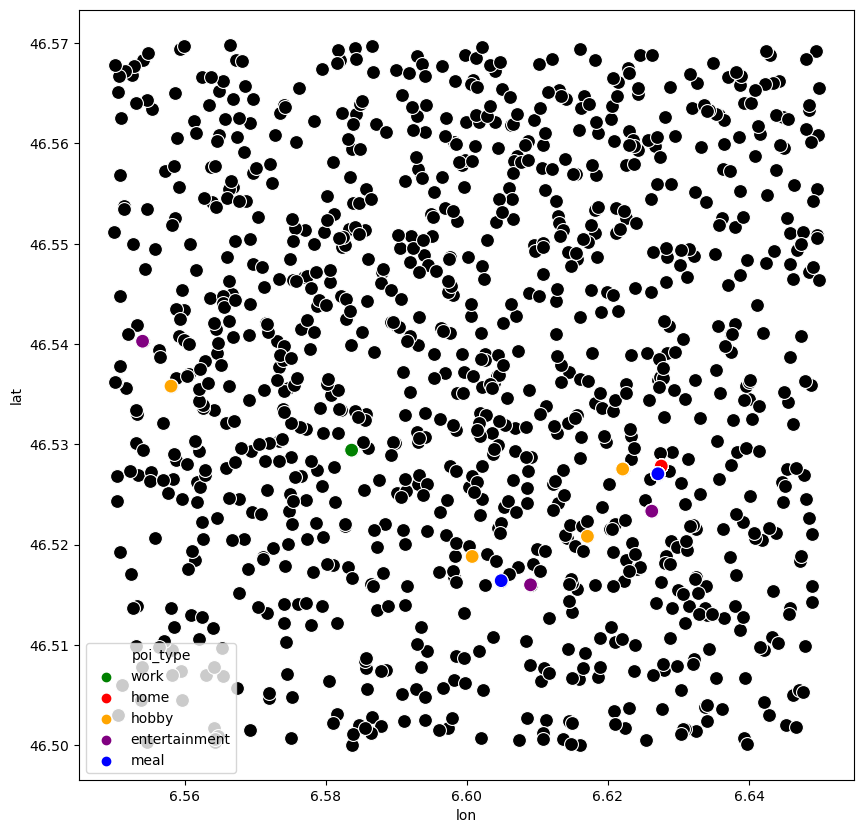

In [11]:
# For better visualization, let's get one user and plot his queries on a map for over a week
# Let's choose the user with the most amount of queries
user, count = queries.groupby('ip_address').count().sort_values(by='day', ascending=False).head(1).index[0], queries.groupby('ip_address').count().sort_values(by='day', ascending=False).head(1).day[0]
print(f'The user with the most amount of queries is {user} with {count} queries')
info = plot_user_queries(user, True)

In [12]:
# Now we repeat the same process for all the users
user_infos = {}
for user in queries['ip_address'].unique():
    user_info = plot_user_queries(user, False)
    unique_home_locations = user_info['home'].groupby(['lat', 'lon']).count().shape[0]
    unique_work_locations = user_info['work'].groupby(['lat', 'lon']).count().shape[0]
    if(unique_home_locations != 1):
        print(f'{user_info["user"]} has {unique_home_locations} home locations')
    if(unique_work_locations != 1):
        print(f'{user_info["user"]} has {unique_work_locations} work locations')
    user_infos[user] = user_info

#### Notice that above we have an if statement to check if a user has more than 1 unique work or home location, and for none of the users this is true.

# Further inferences

We notice from the above cell that each user lives and works in one place. 

We also can assume that no user works in one of the POIs that we have classified as meal, hobby and etc.

With these information we try to infer further information about users, for example we'll try to find users who work in the same place and/or who live in the same place.

We first start with analyzing who lives in what type of home?

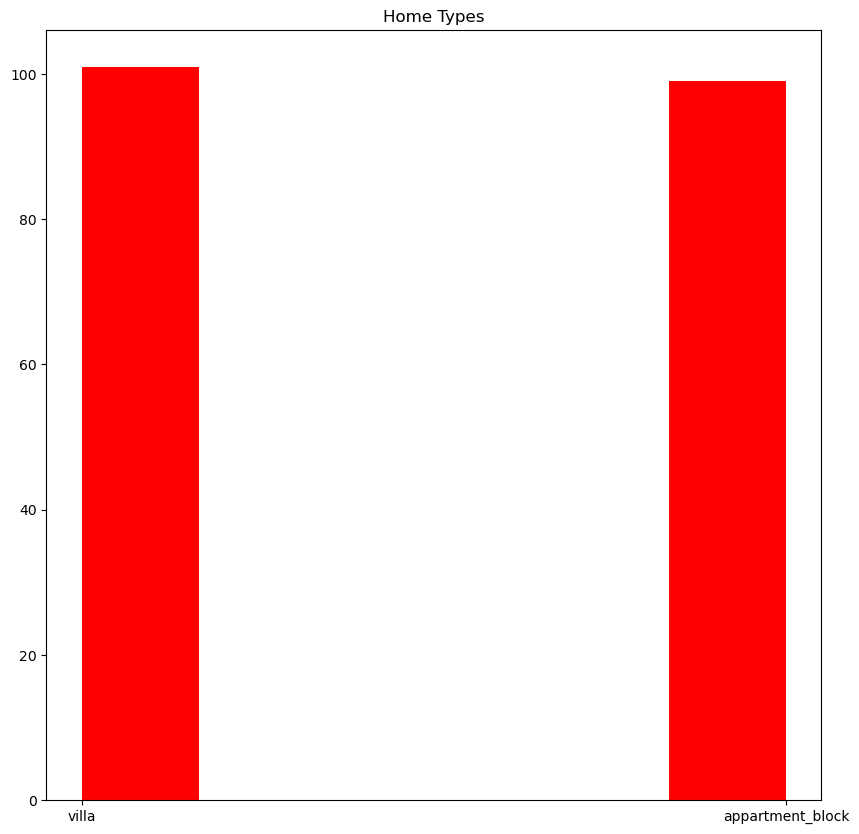

In [13]:
# Plot the type of homes that the users have
home_types = [user_info['home'].iloc[0]['poi_type_original'] for user_info in user_infos.values()]
plt.figure(figsize=(10, 10))
plt.title('Home Types')
plt.hist(home_types, bins=6, color='red')
plt.show()

In [26]:
# Find the users who live in the same house
home_locations = [user_info['home'].iloc[0][['ip_address', 'lat', 'lon']].values for user_info in user_infos.values()]

home_locations = pd.DataFrame(home_locations, columns=['ip_address', 'lat', 'lon'])
home_locations = home_locations.groupby(['lat', 'lon']).apply(lambda x: x['ip_address'].values).rename('ip_addresses').reset_index()


home_locations.head()

,lat,lon,ip_addresses
0,46.504993,6.646247,"[236.195.248.12, 82.249.248.9]"
1,46.507693,6.610972,[121.229.130.24]
2,46.509162,6.616751,[118.135.166.110]
3,46.509939,6.623809,[204.146.211.61]
4,46.510325,6.620991,"[191.78.122.246, 127.4.23.40]"


### Note that label -1 means the point is an outlier, i.e. does NOT belong to any of the clusters. In our case this means the user lives alone.

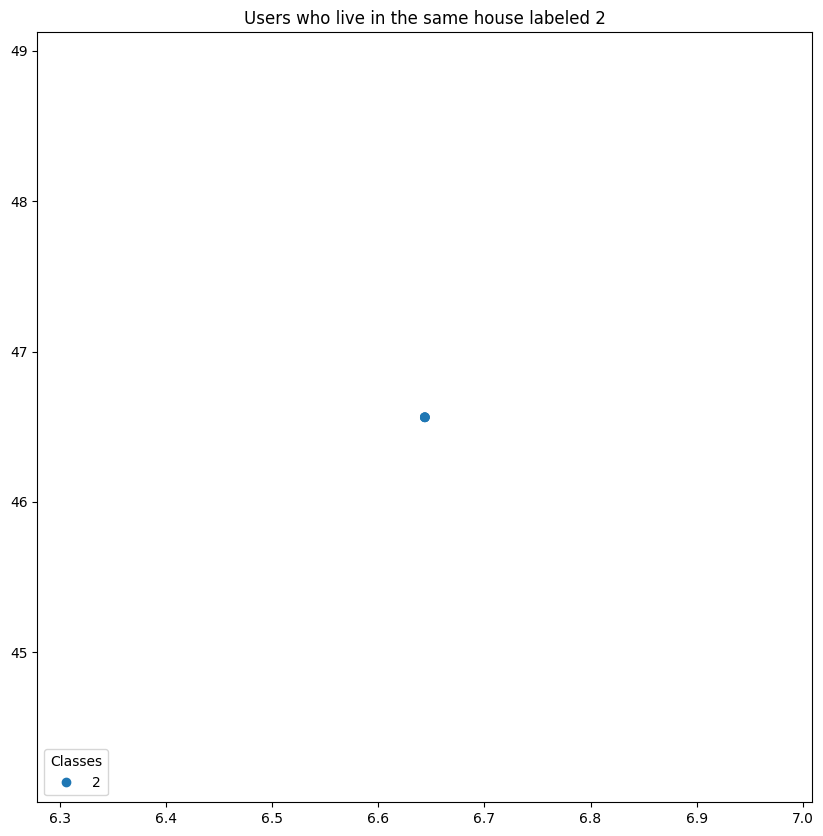

In [14]:
plt.figure(figsize=(10, 10))
plt.title('Users who live in the same house labeled 2')
scatter = plt.scatter(home_locations[home_labels == 2, 1], home_locations[home_labels == 2, 0], c=home_labels[home_labels == 2], cmap='tab20')
# Create a legend
plt.legend(*scatter.legend_elements(), loc="lower left", title="Classes")

Number of people living alone: 71


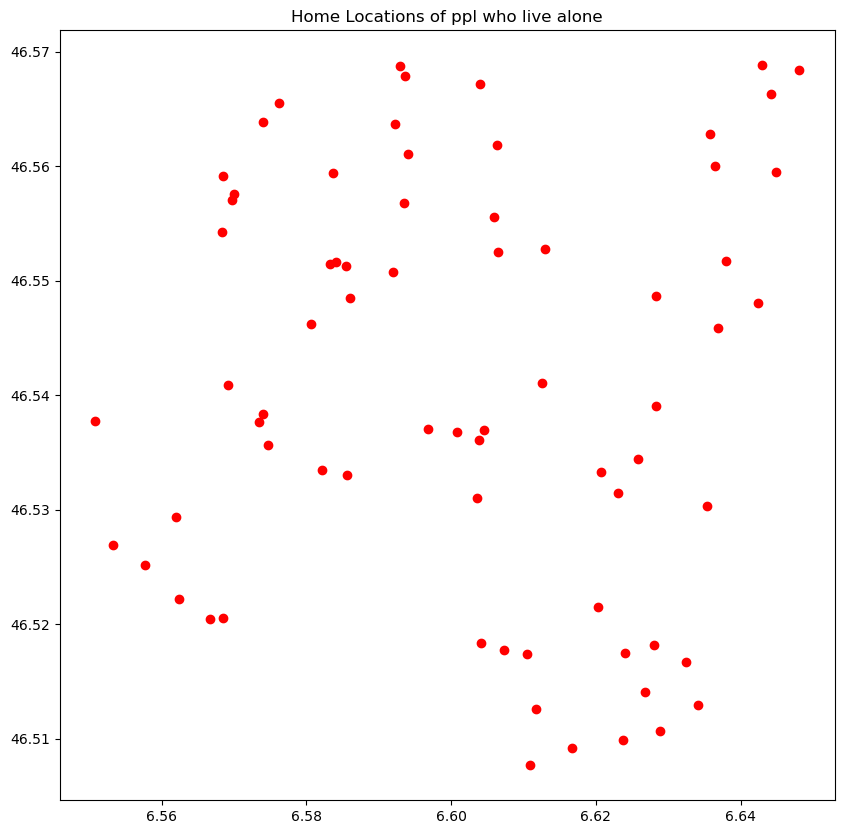

In [29]:
# plot the home locations that have len(ip_addresses) == 1
print(f"Number of people living alone: {home_locations[home_locations['ip_addresses'].apply(lambda x: len(x) == 1)].shape[0]}")
plt.figure(figsize=(10, 10))
plt.title('Home Locations of ppl who live alone')
plt.scatter(home_locations[home_locations['ip_addresses'].apply(lambda x: len(x) == 1)]['lon'], home_locations[home_locations['ip_addresses'].apply(lambda x: len(x) == 1)]['lat'], color='red')
plt.show()

### Now for better visualization we print a table with House Label in one column and user's ip addresses in the other column, along with type of home

In [44]:
# For all the users that don't live alone, print the home_tupe and the number of users that live in that home in nice table using tabulate
home_label_users = home_locations[home_locations['ip_addresses'].apply(lambda x: len(x) != 1)].set_index(['lat', 'lon'])['ip_addresses'].to_dict()

print(tabulate([[key, home_label_users[key], user_infos[home_label_users[key][0]]['home'].iloc[0]['poi_type_original']] for key in home_label_users], headers=['Home Loc', 'Users', 'Home Type'],tablefmt="fancy_grid",stralign="center" ))


╒══════════════════════════════════════════╤════════════════════════════════════════════════════════════════════════╤══════════════════╕
│                 Home Loc                 │                                 Users                                  │    Home Type     │
╞══════════════════════════════════════════╪════════════════════════════════════════════════════════════════════════╪══════════════════╡
│  (46.50499317111984, 6.646247394953719)  │                   ['236.195.248.12' '82.249.248.9']                    │      villa       │
├──────────────────────────────────────────┼────────────────────────────────────────────────────────────────────────┼──────────────────┤
│ (46.510324835038304, 6.620990696572315)  │                    ['191.78.122.246' '127.4.23.40']                    │ appartment_block │
├──────────────────────────────────────────┼────────────────────────────────────────────────────────────────────────┼──────────────────┤
│ (46.513842631757456, 6.631423772304648)

In [45]:
user_infos['34.101.177.245']['home'].drop_duplicates(subset=['lat', 'lon'])

,ip_address,lat,lon,timestamp,poi_type_query,day_of_week,hour_of_day,day,poi_type_query_original,poi_id,cell_id,poi_type,poi_type_original
30,34.101.177.245,46.550342,6.602852,18.024657,meal,0.0,18,0.0,restaurant,127,76,home,villa


In [46]:
user_infos['189.222.3.241']['home'].drop_duplicates(subset=['lat', 'lon'])

,ip_address,lat,lon,timestamp,poi_type_query,day_of_week,hour_of_day,day,poi_type_query_original,poi_id,cell_id,poi_type,poi_type_original
30,189.222.3.241,46.550342,6.602852,19.587954,entertainment,0.0,19,0.0,club,127,76,home,villa


1    71
2    34
3    12
4     5
5     1
dtype: int64

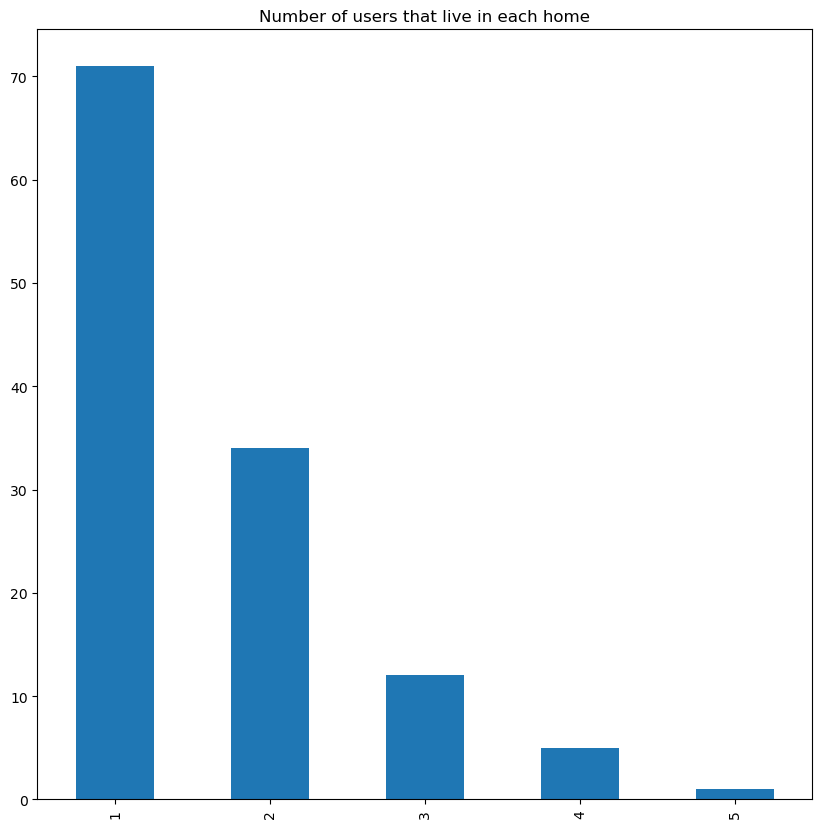

In [47]:
# Group home_locations by the len(ip_addresses) and plot the number of users that live in each home
living_count = home_locations.apply(lambda x: len(x['ip_addresses']), axis=1).value_counts()
living_count.plot(kind='bar', figsize=(10, 10), title='Number of users that live in each home')
living_count.head()

### We can do the same analysis for finding users working in the same place as well.

In [48]:
# We repeat the same process for work locations
work_locations = [user_info['work'].iloc[0][['ip_address', 'lat', 'lon']].values for user_info in user_infos.values()]

work_locations = pd.DataFrame(work_locations, columns=['ip_address', 'lat', 'lon'])
work_locations = work_locations.groupby(['lat', 'lon']).apply(lambda x: x['ip_address'].values).rename('ip_addresses').reset_index()

work_locations.head()

,lat,lon,ip_addresses
0,46.513707,6.558102,"[78.204.108.127, 156.148.169.71, 27.162.61.209]"
1,46.519792,6.587302,"[19.209.233.227, 106.44.169.163, 37.52.192.45,..."
2,46.520003,6.591260,"[229.89.219.178, 175.43.40.163]"
3,46.520794,6.579619,"[247.70.122.201, 197.134.251.204, 148.184.155...."
4,46.520903,6.613859,"[118.135.166.110, 163.177.121.157, 52.35.191.21]"


### Now for better visualization we print a table with work Label in one column and user's ip addresses in the other column, along with type of work place

In [49]:
# For all the users, print the work type and the number of users that work in that location in nice table using tabulate
work_label_users = work_locations[work_locations['ip_addresses'].apply(lambda x: len(x) != 1)].set_index(['lat', 'lon'])['ip_addresses'].to_dict()

print(tabulate([[key, work_label_users[key], user_infos[work_label_users[key][0]]['work'].iloc[0]['poi_type_original']] for key in work_label_users], headers=['Work Loc', 'Users', 'Work Type'],tablefmt="fancy_grid",stralign="center" ))

╒══════════════════════════════════════════╤═══════════════════════════════════════════════════════════════════════╤═════════════╕
│                 Work Loc                 │                                 Users                                 │  Work Type  │
╞══════════════════════════════════════════╪═══════════════════════════════════════════════════════════════════════╪═════════════╡
│ (46.513706793542674, 6.558102491752225)  │          ['78.204.108.127' '156.148.169.71' '27.162.61.209']          │   office    │
├──────────────────────────────────────────┼───────────────────────────────────────────────────────────────────────┼─────────────┤
│ (46.519792245810606, 6.587302357717578)  │  ['19.209.233.227' '106.44.169.163' '37.52.192.45' '61.173.242.232'   │ laboratory  │
│                                          │                           '115.186.150.175']                          │             │
├──────────────────────────────────────────┼───────────────────────────────────────

### Now finally, it is also possible to repeat this experiment but by using both the work place and home place

In [69]:
# Now repeat the above processes but this time use both home and work locations to find users who live and work in the same place
# Firstly for each user in user_infos, we concatenate the home and work locations
home_work_locations = {}
for user in user_infos:
        # we concatenate the first row of home and work locations, only get the lat and lon columns
        home_work_locations[user] = pd.concat([user_infos[user]['home'].iloc[0][['lat', 'lon']], user_infos[user]['work'].iloc[0][['lat', 'lon']]]).values
        # rename the lat lon columns to home_lan and home_lon and work_lat and work_lon
        home_work_locations[user] = pd.DataFrame(home_work_locations[user].reshape(1, 4), columns=['home_lat', 'home_lon', 'work_lat', 'work_lon'])

# Now we convert the dictionary to a dataframe
home_work_locations = pd.concat(home_work_locations).reset_index().drop('level_1', axis=1).rename(columns={'level_0': 'ip_address'})
# to find users who live and work together we group by the home and work locations
home_work_locations = home_work_locations.groupby(['home_lat', 'home_lon', 'work_lat', 'work_lon']).apply(lambda x: x['ip_address'].values).rename('ip_addresses').reset_index()
# keep the home and work locations that have more than 1 user
home_work_locations = home_work_locations[home_work_locations['ip_addresses'].apply(lambda x: len(x) != 1)]
home_work_locations.head()

,home_lat,home_lon,work_lat,work_lon,ip_addresses
18,46.516371,6.622289,46.523222,6.569618,"[37.238.140.76, 245.191.255.251, 131.210.249.71]"
72,46.533486,6.574006,46.526062,6.594416,"[113.244.164.228, 126.107.209.19]"
162,46.560144,6.598204,46.564897,6.624232,"[135.104.79.52, 233.228.129.122]"
193,46.569210,6.649531,46.539761,6.574063,"[210.68.124.185, 242.216.225.78]"


In [ ]:
print(tabulate([[key, home_work_locations[home_work_locations['ip_addresses'].apply(lambda x: len(x) != 1)].set_index(['home_lat', 'home_lon', 'work_lat', 'work_lon'])['ip_addresses'][key], user_infos[home_work_locations[home_work_locations['ip_addresses'].apply(lambda x: len(x) != 1)].set_index(['home_lat', 'home_lon', 'work_lat', 'work_lon'])['ip_addresses'][key][0]]['home'].iloc[0]['poi_type_original'], user_infos[home_work_locations[home_work_locations['ip_addresses'].apply(lambda x: len(x) != 1)].set_index(['home_lat', 'home_lon', 'work_lat', 'work_lon'])['ip_addresses'][key][0]]['work'].iloc[0]['poi_type_original']] for key in home_work_locations[home_work_locations['ip_addresses'].apply(lambda x: len(x) != 1)].set_index(['home_lat', 'home_lon', 'work_lat', 'work_lon'])['ip_addresses'].to_dict()], headers=['Home Work Loc', 'Users', 'Home Type', 'Work Type'],tablefmt="fancy_grid",stralign="center" ))

In [79]:
# Print a fancy table with tabulate that has 4 columns:
# where one column is the home_work label and the other labels are the users ip addresses who live and work in that place, final 2 columns are the type of home and work, retrieved from poi_type_original
# Skip label -1 because it is the label for users who live and work alone
home_work_label_users = home_work_locations.set_index(['home_lat', 'home_lon', 'work_lat', 'work_lon'])['ip_addresses'].to_dict()

print(tabulate([[key, home_work_label_users[key], user_infos[home_work_label_users[key][0]]['home'].iloc[0]['poi_type_original'], user_infos[home_work_label_users[key][0]]['work'].iloc[0]['poi_type_original']] for key in home_work_label_users if key != -1], headers=['Home Work Label', 'Users', 'Home Type', 'Work Type'],tablefmt="fancy_grid",stralign="center" ))

╒═══════════════════════════════════════════════════════════════════════════════╤══════════════════════════════════════════════════════╤═════════════╤═════════════╕
│                                Home Work Label                                │                        Users                         │  Home Type  │  Work Type  │
╞═══════════════════════════════════════════════════════════════════════════════╪══════════════════════════════════════════════════════╪═════════════╪═════════════╡
│ (46.51637128568548, 6.622289267252754, 46.523222357067546, 6.569618055391519) │ ['37.238.140.76' '245.191.255.251' '131.210.249.71'] │    villa    │   office    │
├───────────────────────────────────────────────────────────────────────────────┼──────────────────────────────────────────────────────┼─────────────┼─────────────┤
│ (46.53348639823881, 6.574006110717793, 46.52606201484912, 6.5944159957331925) │         ['113.244.164.228' '126.107.209.19']         │    villa    │ laboratory  │
├─────────

In [71]:
user_infos['135.104.79.52']['home'].groupby(['ip_address', 'lat', 'lon']).size().reset_index(name='count')[['ip_address', 'lat','lon']]

,ip_address,lat,lon
0,135.104.79.52,46.560144,6.598204


In [72]:
user_infos['233.228.129.122']['home'].groupby(['ip_address','lat', 'lon']).size().reset_index(name='count')[['ip_address','lat','lon']]

,ip_address,lat,lon
0,233.228.129.122,46.560144,6.598204


In [73]:
user_infos['135.104.79.52']['work'].groupby(['ip_address', 'lat', 'lon']).size().reset_index(name='count')[['ip_address', 'lat','lon']]

,ip_address,lat,lon
0,135.104.79.52,46.564897,6.624232


In [74]:
user_infos['233.228.129.122']['work'].groupby(['ip_address','lat', 'lon']).size().reset_index(name='count')[['ip_address','lat','lon']]

,ip_address,lat,lon
0,233.228.129.122,46.564897,6.624232


#### Why this analysis makes sense is simple, when we analyze people who are living together, an attacker has 2 inferences he/she can make. Either these people are family that live together or they are roommates. In both cases, the attacker can infer that these people are close to each other and have a high chance of being friends.

#### But when we also put the work place into the equation, we can infer that these people are most likely colleagues if they also work in the same place while also living together.

In [101]:
print(f"home: {user_infos['62.87.46.15']['home'].iloc[0][['ip_address', 'lat', 'lon']]} | work: {user_infos['62.87.46.15']['work'].iloc[0][['ip_address', 'lat', 'lon']]}")

home: ip_address    62.87.46.15
lat             46.516371
lon              6.622289
Name: 30, dtype: object | work: ip_address    62.87.46.15
lat             46.542679
lon              6.593288
Name: 0, dtype: object


In [102]:
print(f"home: {user_infos['37.238.140.76']['home'].iloc[0][['ip_address', 'lat', 'lon']]} | work: {user_infos['37.238.140.76']['work'].iloc[0][['ip_address', 'lat', 'lon']]}")

home: ip_address    37.238.140.76
lat               46.516371
lon                6.622289
Name: 30, dtype: object | work: ip_address    37.238.140.76
lat               46.523222
lon                6.569618
Name: 0, dtype: object


In [116]:
# Find out people who live together but work in different places
# we have home_label_users and work_label_users
# in home_label_users we have to find the users who don't work in the same place
family_members = {}
i = 0
for home_label in home_label_users:
    # find everyone's work location
    work_locations = [user_infos[user]['work'].iloc[0][['ip_address', 'lat', 'lon']].values for user in home_label_users[home_label]]
    # group by the work locations
    work_locations = pd.DataFrame(work_locations, columns=['ip_address', 'lat', 'lon']).groupby(['lat', 'lon']).apply(lambda x: x['ip_address'].values).rename('ip_addresses').reset_index()
    # add the ip addresses that have len == 1
    work_locations = work_locations[work_locations['ip_addresses'].apply(lambda x: len(x) == 1)]
work_locations.head()


,lat,lon,ip_addresses
0,46.525781,6.600312,[82.230.180.56]
1,46.529415,6.583668,[146.148.99.165]
2,46.539761,6.574063,"[210.68.124.185, 242.216.225.78]"
3,46.540782,6.591897,[140.84.18.65]


### Below we do a small check that the family groups we formed are correct, i.e. people in the same group/family do live together & do not work in the same place.

In [92]:
for key in family_label_users:
    users = family_label_users[key]
    # Check if this family works in the same place
    for user in users:
        for key2 in home_work_label_users:
            if user in home_work_label_users[key2] and key2 != -1:
                print(key, key2, user)
    
    home_places = [user_infos[user]['home'].iloc[0][['lat', 'lon']].values for user in users]
    home_places = set([tuple(place) for place in home_places])
    if len(home_places) != 1:
        print('Different home places for family', key)

(46.56014415936724, 6.598203678264672) (46.56014415936724, 6.598203678264672, 46.56489716353281, 6.624231814027893) 135.104.79.52
(46.56014415936724, 6.598203678264672) (46.56014415936724, 6.598203678264672, 46.56489716353281, 6.624231814027893) 233.228.129.122


# Other Inferences: Using Shopping, Meal, Hobby and etc. POIs

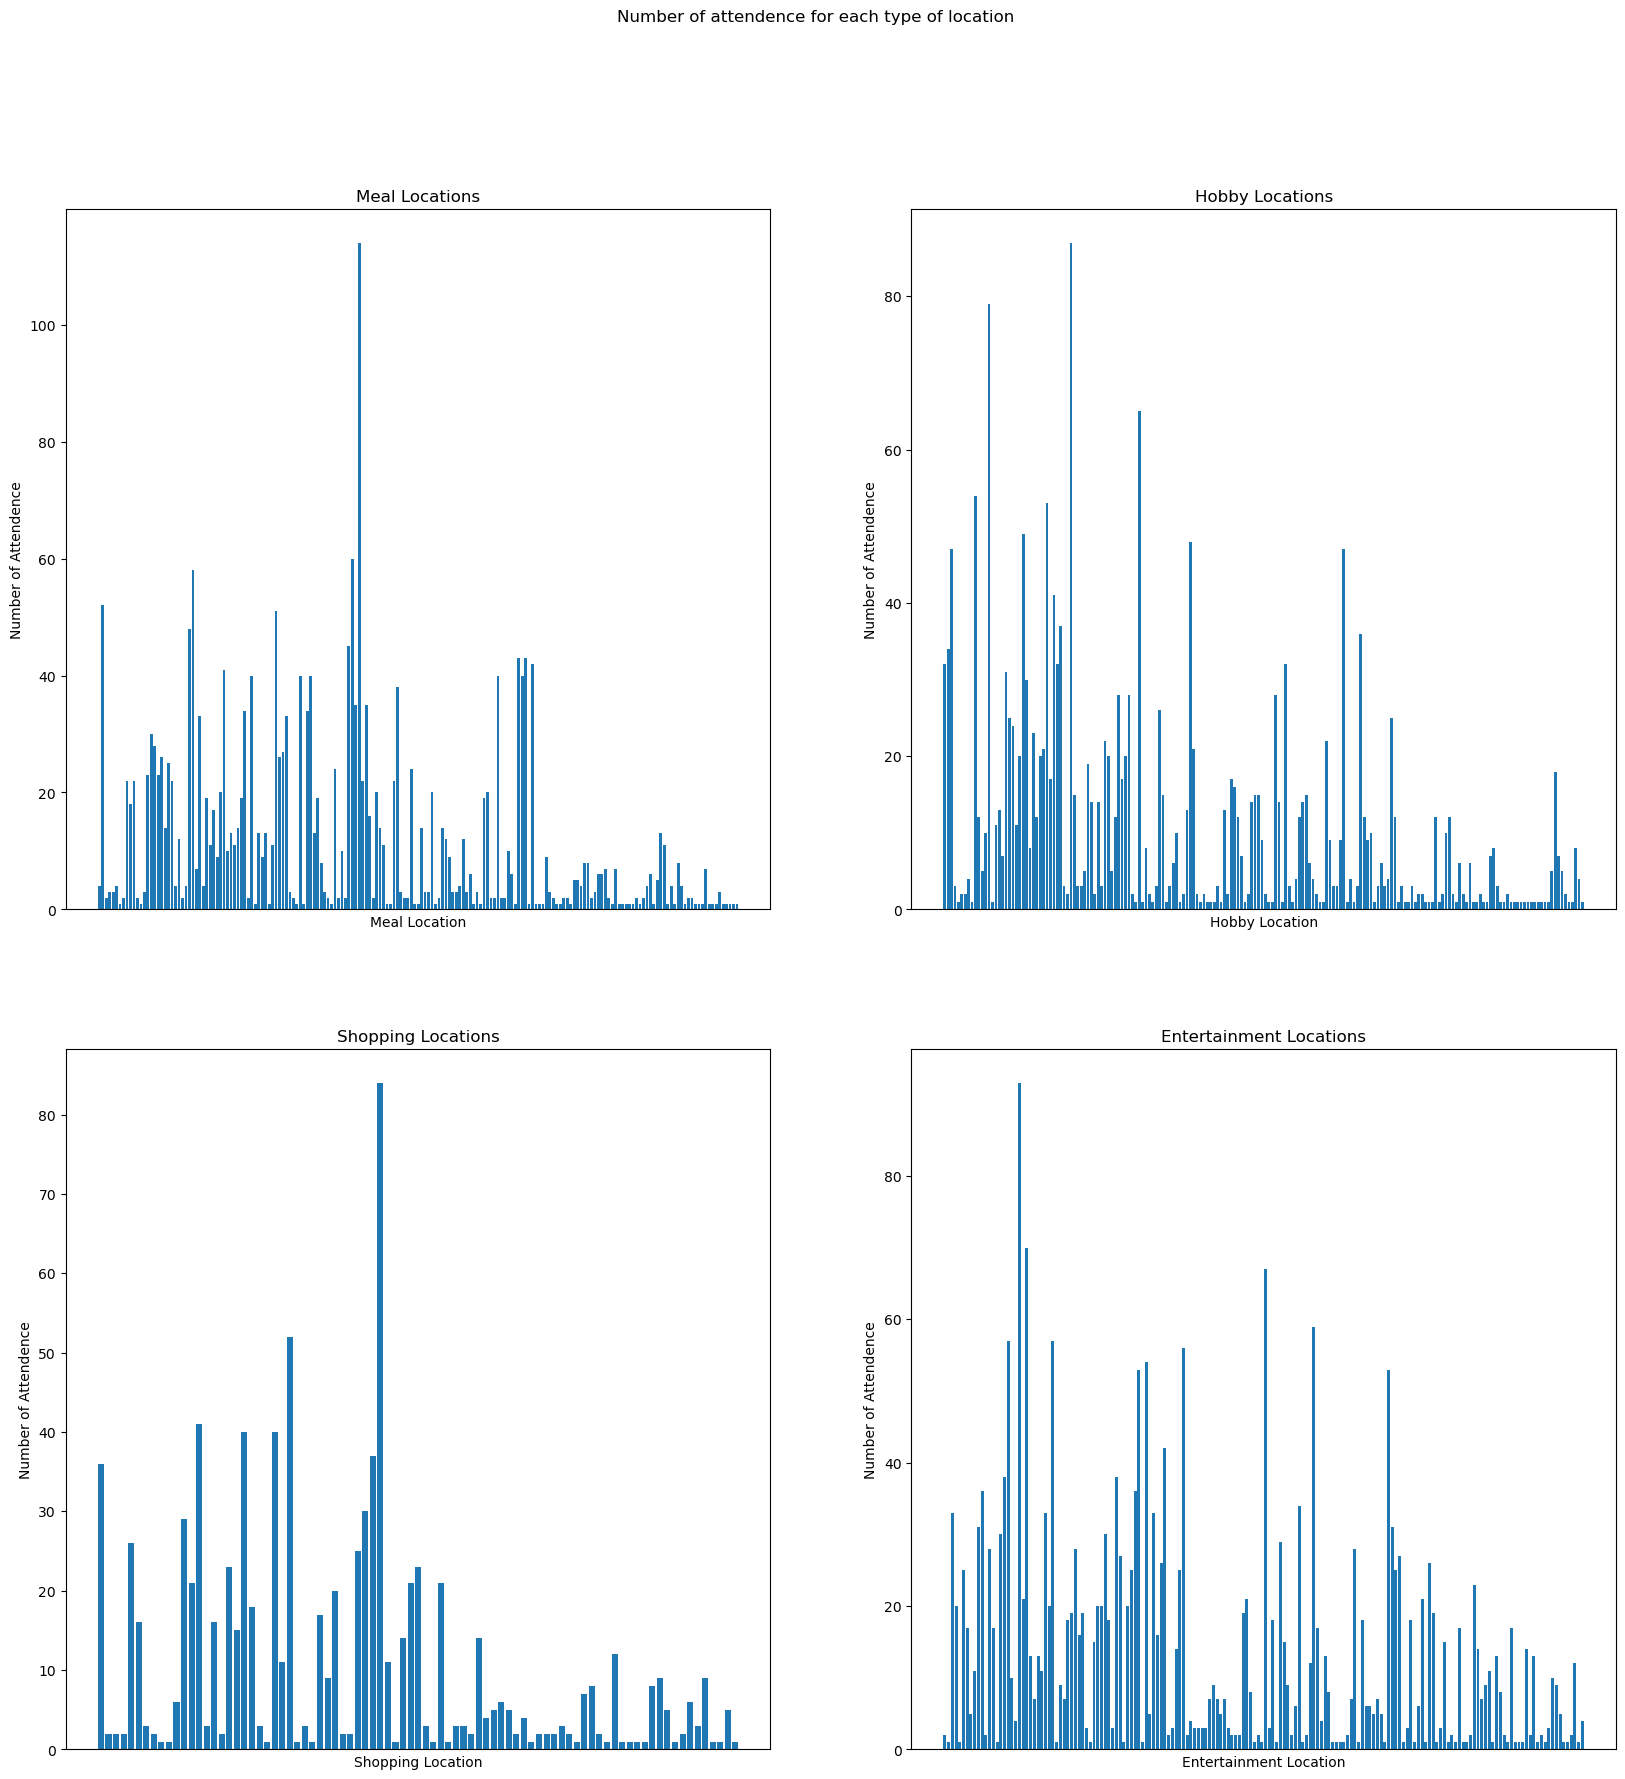

In [76]:
# Now we will be looking at other types of locations, such as Meal, Hobby, Shopping entertainement etc.
# First thing we can take a look at is the number of attendence for each type of location
# We will be using the poi_type column to get the type of location
# For each of these locations we will have one plot
# So one plot for Meal, one plot for Hobby, one plot for Shopping, one plot for Entertainment

# In each of these plots we will have one bar for each sub-type of location,
# To be able to do this we will need to get the sub-type of location for each location
# We will use the lat, lon coordinates to get the sub-type of location
# We will use the poi_type column to get the type of location
fig, ax = plt.subplots(2, 2, figsize=(20, 20))
fig.suptitle('Number of attendence for each type of location')

meal_locations = {}
hobby_locations = {}
shopping_locations = {}
entertainment_locations = {}

for user_info in user_infos.values():
    # Get the meal locations:
    user_meal_locations = user_info['meal'][['lat', 'lon']].values
    for user_meal_location in user_meal_locations:
        if tuple(user_meal_location) not in meal_locations:
            meal_locations[tuple(user_meal_location)] = 0
        meal_locations[tuple(user_meal_location)] += 1
        #print(f'User: {user_info["user"]} has attended a meal at location: {tuple(user_meal_location)} at time: {user_info["meal"].iloc[0]["day"]}|{user_info["meal"].iloc[0]["hour_of_day"]}')
    
    # Get the hobby locations:
    user_hobby_locations = user_info['hobby'][['lat', 'lon']].values
    for user_hobby_location in user_hobby_locations:
        if tuple(user_hobby_location) not in hobby_locations:
            hobby_locations[tuple(user_hobby_location)] = 0
        hobby_locations[tuple(user_hobby_location)] += 1
    
    # Get the shopping locations:
    user_shopping_locations = user_info['shopping'][['lat', 'lon']].values
    for user_shopping_location in user_shopping_locations:
        if tuple(user_shopping_location) not in shopping_locations:
            shopping_locations[tuple(user_shopping_location)] = 0
        shopping_locations[tuple(user_shopping_location)] += 1
    
    # Get the entertainment locations:
    user_entertainment_locations = user_info['entertainment'][['lat', 'lon']].values
    for user_entertainment_location in user_entertainment_locations:
        if tuple(user_entertainment_location) not in entertainment_locations:
            entertainment_locations[tuple(user_entertainment_location)] = 0
        entertainment_locations[tuple(user_entertainment_location)] += 1
    

# Now we have 4 dictionaries, each dictionary has the coordinates of the location as the key and the number of attendence as the value
# We will now plot these dictionaries

# Plot the meal locations
ax[0, 0].set_title('Meal Locations')
ax[0, 0].set_xlabel('Meal Location')
ax[0, 0].set_ylabel('Number of Attendence')
# Remove x axis ticks
ax[0, 0].set_xticks([])
ax[0, 0].bar([str(key) for key in meal_locations], [meal_locations[key] for key in meal_locations])

# Plot the hobby locations
ax[0, 1].set_title('Hobby Locations')
ax[0, 1].set_xlabel('Hobby Location')
ax[0, 1].set_ylabel('Number of Attendence')
# Remove x axis ticks
ax[0, 1].set_xticks([])
ax[0, 1].bar([str(key) for key in hobby_locations], [hobby_locations[key] for key in hobby_locations])

# Plot the shopping locations
ax[1, 0].set_title('Shopping Locations')
ax[1, 0].set_xlabel('Shopping Location')
ax[1, 0].set_ylabel('Number of Attendence')
# Remove x axis ticks
ax[1, 0].set_xticks([])
ax[1, 0].bar([str(key) for key in shopping_locations], [shopping_locations[key] for key in shopping_locations])

# Plot the entertainment locations
ax[1, 1].set_title('Entertainment Locations')
ax[1, 1].set_xlabel('Entertainment Location')
ax[1, 1].set_ylabel('Number of Attendence')
# Remove x axis ticks
ax[1, 1].set_xticks([])
ax[1, 1].bar([str(key) for key in entertainment_locations], [entertainment_locations[key] for key in entertainment_locations])

plt.show()





In [77]:
# Find the most popular meal, hobby, shopping and entertainment locations

# First the meal location
# We will use the meal_locations dictionary that we created above
# We will sort the dictionary by the number of attendence
for key in sorted(meal_locations, key=meal_locations.get, reverse=True):
    print(f"Most popular meal {key}:{ meal_locations[key]}")
    break

# Now the hobby location
for key in sorted(hobby_locations, key=hobby_locations.get, reverse=True):
    print(f"Most popular hobby {key}:{ hobby_locations[key]}")
    break

# Now the shopping location
for key in sorted(shopping_locations, key=shopping_locations.get, reverse=True):
    print(f"Most popular shopping {key}:{ shopping_locations[key]}")
    break

# Now the entertainment location
for key in sorted(entertainment_locations, key=entertainment_locations.get, reverse=True):
    print(f"Most popular entertainment {key}:{ entertainment_locations[key]}")
    break


Most popular meal (46.515853182301285, 6.620696945936285):114
Most popular hobby (46.539318537853006, 6.607186289538898):87
Most popular shopping (46.51907799910527, 6.623836875862341):84
Most popular entertainment (46.529155702669506, 6.627355926244203):93


### Next thing we will be looking at is trying to find users who hang out together at the same time, i.e they go to the same POI at the same time.

### The first thing that can be tried, because we already have the family members grouped together, we can try to see when they go out to eat together or go shopping together etc.

In [32]:
# Now using the family_label_users dictionary, we will try to find when these family members go to a POI together at the same time.

for key in family_label_users:
    users = family_label_users[key]
    # Combine the Meal, Hobby, Shopping and Entertainment dataframes for each user
    meal_places = [user_infos[user]['meal'] for user in users]
    hobby_places = [user_infos[user]['hobby'] for user in users]
    shopping_places = [user_infos[user]['shopping'] for user in users]
    entertainment_places = [user_infos[user]['entertainment'] for user in users]
    # Now for meal places, group by lat,lon and timestamp
    meal_places = pd.concat(meal_places)
    meal_places = meal_places.groupby(['lat', 'lon', 'hour_of_day', 'day']).apply(lambda x: x['ip_address'].unique() if len(x['ip_address'].unique()) > 1 else None)
    # Drop rows that have None as the value
    meal_places = meal_places.dropna()
    # Now for hobby places, group by lat,lon and timestamp
    hobby_places = pd.concat(hobby_places)
    hobby_places = hobby_places.groupby(['lat', 'lon', 'hour_of_day', 'day']).apply(lambda x: x['ip_address'].unique() if len(x['ip_address'].unique()) > 1 else None)
    # Drop rows that have None as the value
    hobby_places = hobby_places.dropna()
    # Now for shopping places, group by lat,lon and timestamp
    shopping_places = pd.concat(shopping_places)
    shopping_places = shopping_places.groupby(['lat', 'lon', 'hour_of_day', 'day']).apply(lambda x: x['ip_address'].unique() if len(x['ip_address'].unique()) > 1 else None)
    # Drop rows that have None as the value
    shopping_places = shopping_places.dropna()
    # Now for entertainment places, group by lat,lon and timestamp
    entertainment_places = pd.concat(entertainment_places)
    entertainment_places = entertainment_places.groupby(['lat', 'lon', 'hour_of_day', 'day']).apply(lambda x: x['ip_address'].unique() if len(x['ip_address'].unique()) > 1 else None)
    # Drop rows that have None as the value
    entertainment_places = entertainment_places.dropna()
    family_label_users[key] = {
        'users': users,
        'meal': meal_places,
        'hobby': hobby_places,
        'shopping': shopping_places,
        'entertainment': entertainment_places
    }


/var/folders/75/94jyvgc92_gcwmzgrg36xfd00000gn/T/ipykernel_2015/2660564934.py:22: FutureWarning: Not prepending group keys to the result index of transform-like apply. In the future, the group keys will be included in the index, regardless of whether the applied function returns a like-indexed object.
To preserve the previous behavior, use

	>>> .groupby(..., group_keys=False)

To adopt the future behavior and silence this warning, use 

	>>> .groupby(..., group_keys=True)
  shopping_places = shopping_places.groupby(['lat', 'lon', 'hour_of_day', 'day']).apply(lambda x: x['ip_address'].unique() if len(x['ip_address'].unique()) > 1 else None)
/var/folders/75/94jyvgc92_gcwmzgrg36xfd00000gn/T/ipykernel_2015/2660564934.py:12: FutureWarning: Not prepending group keys to the result index of transform-like apply. In the future, the group keys will be included in the index, regardless of whether the applied function returns a like-indexed object.
To preserve the previous behavior, use

	>>> .gr

In [33]:
# Find in family_label_users any non-empty meal, hobby, shopping and entertainment locations
for key in family_label_users:
    users = family_label_users[key]['users']
    toBePrinted = f"Family members {users}: \n"
    if len(family_label_users[key]['meal']) > 0:
        toBePrinted += "\t Meals: \n"
        locations = family_label_users[key]['meal'].reset_index()
        for index, row in locations.iterrows():
            toBePrinted += f"\t\t {row[0]} {row['lat']},{row['lon']} at {row['hour_of_day']}.00 on Day:{row['day']} for a meal \n"
    if len(family_label_users[key]['hobby']) > 0:
        toBePrinted += "\t Hobbies: \n"
        locations = family_label_users[key]['hobby'].reset_index()
        for index, row in locations.iterrows():
            toBePrinted += f"\t\t {row[0]} {row['lat']},{row['lon']} at {row['hour_of_day']}.00 on Day:{row['day']} for a hobby \n"
    if len(family_label_users[key]['shopping']) > 0:
        toBePrinted += "\t Shopping: \n"
        locations = family_label_users[key]['shopping'].reset_index()
        for index, row in locations.iterrows():
            toBePrinted += f"\t\t {row[0]} {row['lat']},{row['lon']} at {row['hour_of_day']}.00 on Day:{row['day']} for shopping \n"
    if len(family_label_users[key]['entertainment']) > 0:
        toBePrinted += "\t Entertainment: \n"
        locations = family_label_users[key]['entertainment'].reset_index()
        for index, row in locations.iterrows():
            toBePrinted += f"\t\t {row[0]} {row['lat']},{row['lon']} at {row['hour_of_day']}.00 on Day:{row['day']} for entertainment \n"
    if (toBePrinted != f"Family members {users}: \n"):
        print(toBePrinted)
        print("_______________\n")

Family members ['34.101.177.245', '189.222.3.241']: 
	 Hobbies: 
		 ['34.101.177.245' '189.222.3.241'] 46.54988036021286,6.609448555546026 at 8.00 on Day:19.0 for a hobby 

_______________

Family members ['244.190.169.115', '166.3.233.225', '103.75.228.13']: 
	 Meals: 
		 ['244.190.169.115' '103.75.228.13'] 46.54772014845813,6.649023102470785 at 8.00 on Day:13.0 for a meal 
	 Entertainment: 
		 ['244.190.169.115' '166.3.233.225'] 46.54637046724508,6.649892848816985 at 22.00 on Day:1.0 for entertainment 

_______________

Family members ['60.235.63.253', '96.128.153.246', '18.204.22.223']: 
	 Meals: 
		 ['96.128.153.246' '18.204.22.223'] 46.560171909490215,6.648719746247985 at 19.00 on Day:10.0 for a meal 

_______________

Family members ['115.207.37.109', '121.125.118.222', '13.103.179.102']: 
	 Meals: 
		 ['115.207.37.109' '121.125.118.222'] 46.544497023669706,6.582856908567262 at 19.00 on Day:10.0 for a meal 
	 Hobbies: 
		 ['115.207.37.109' '13.103.179.102'] 46.547510956525954,6.5

# Per person pattern analysis

### In this part, we'll be analyzing a specific user's patterns, i.e try to see where he/she is on average at a specific time of the day(for everyday of the week).

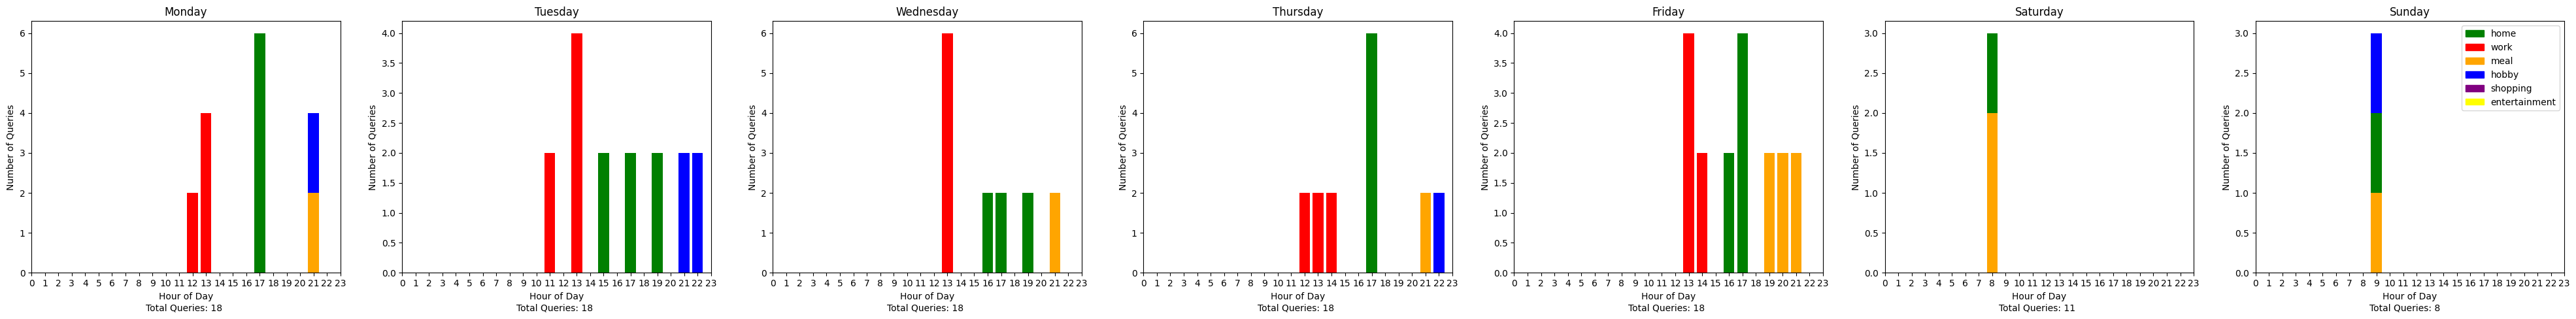

In [34]:
# This function takes a user's ip address and does the following:
# Create 7 graphs, one for each day of the week
# Each graph shows the average number of queries per hour for that day
# The bars are coloured based on where the user was at that time
import matplotlib.patches as mpatches
poi_colours = {
    'home': 'green',
    'work': 'red',
    'meal': 'orange',
    'hobby': 'blue',
    'shopping': 'purple',
    'entertainment': 'yellow'
}

def graph_pattern(user):
    user_queries = queries[queries['ip_address'] == user]
    # Join with the pois
    user_queries = user_queries.merge(pois, on=['lat', 'lon'], how='inner')
    # Now group by day and hour of day and poi_type
    user_queries = user_queries.groupby(['day_of_week', 'hour_of_day', 'poi_type']).count().reset_index()    # Now create a graph for each day
    fig, ax = plt.subplots(1, 7, figsize=(50, 5))
    for day in range(0, 7):
        # Get the queries for that day
        day_queries = user_queries[user_queries['day_of_week'] == day]
        # Plot the frequency per hour of day, colour part of the bar based on the poi_type
        ax[day].bar(day_queries['hour_of_day'], day_queries['ip_address'], color=day_queries['poi_type'].apply(lambda x: poi_colours[x]))
        ax[day].set_title(f"{DAY_MAP[day]}")
        ax[day].set_xlabel("Hour of Day")
        ax[day].set_ylabel("Number of Queries")
        # Set the x axis ticks to be the hours of the day
        ax[day].set_xticks(range(0, 24))
        ax[day].set_xticklabels(range(0, 24))
        # Write the total amount of queries for that day below the graph
        ax[day].text(0.37, -0.15, f"Total Queries: {day_queries['ip_address'].sum()}", transform=ax[day].transAxes)
    # Show a legend for the colours
    plt.legend(handles=[mpatches.Patch(color=poi_colours[key], label=key) for key in poi_colours])
    plt.show()

graph_pattern('113.167.82.177')

### We can clearly see that this specific user is at work till around 16 on weekdays and then goes home. After his work days he tends to go to a hobby location or a meal location. On weekends he tends to go to a meal location and then a hobby location. 
### Using our previous user_infos analysis, we can try to see if these locations he visits are always the same.

In [35]:
user_infos['113.167.82.177']['meal'].groupby(['lat','lon', 'poi_type_original']).count().reset_index()

,lat,lon,poi_type_original,ip_address,timestamp,poi_type_query,day_of_week,hour_of_day,day,poi_type_query_original,poi_id,cell_id,poi_type
0,46.516394,6.604863,cafeteria,1,1,1,1,1,1,1,1,1,1
1,46.527056,6.627076,cafeteria,14,14,14,14,14,14,14,14,14,14


In [36]:
user_infos['113.167.82.177']['hobby'].groupby(['lat','lon', 'poi_type_original']).count().reset_index()

,lat,lon,poi_type_original,ip_address,timestamp,poi_type_query,day_of_week,hour_of_day,day,poi_type_query_original,poi_id,cell_id,poi_type
0,46.518808,6.600750,gym,1,1,1,1,1,1,1,1,1,1
1,46.520822,6.617086,gym,1,1,1,1,1,1,1,1,1,1
2,46.527531,6.622082,dojo,15,15,15,15,15,15,15,15,15,15
3,46.535801,6.558075,gym,1,1,1,1,1,1,1,1,1,1


### We can see that he tends to go to the same meal location which is a cafeteria and the same hobby location which is a gym.

# Defence


In the previous cells we have seen that it is possible to infer a lot of information about users. The main reason why these inferences were possible was due to the fact that each user shared their exact position when querying. This allowed an adversary that has access to another public dataset(the POIs dataset in our case) to mount the attacks described above.

Considering these, we will be trying to defend against these attacks by adding noise to the user's location when querying. Specifically, we will be looking into the mechanism called Differential Privacy, more specifically for Location privacy this is called Geo-Indistinguishability. This mechanism works by adding a Laplacian noise to the real location provided by the user, this is done on the client side before sending the query to the server. The important factor to be considered here is that the noise added should be large enough to prevent the adversary from mounting the previous attacks but also small enough to not affect the accuracy of the query results, as the server still needs to be able to return POIs that are close to the user's location, if the noise is too large then the application will be unusable, i.e. no utility.

On how this point will be generated, we will be following this paper: https://arxiv.org/abs/1212.1984


"To formalize this notion, we consider the level of privacy within a radius. We say that the user enjoys l-privacy within r if, any two locations at dis- tance at most r produce observations with “similar” distributions, where the “level of similarity” depends on l. The idea is that l represents the user’s level of privacy for that radius: the smaller l is, the higher is the privacy.
In order to allow the LBS to provide a useful service, we require that the (inverse of the) level of privacy l depend on the radius r. In particular, we require that it is proportional to r, which brings us to our definition of geo-indistinguishability:

**A mechanism satisfies ε-geo-indistinguishability iff for any radius r > 0, the user enjoys εr-privacy within r.**


This definition implies that the user is protected within any radius r, but with a level l = εr that increases with the distance. Within a short radius, for instance r = 1 km, l is small, guaranteeing that the provider cannot infer the user’s location within, say, the 7th ar- rondissement of Paris. Farther away from the user, for instance for r = 1000 km, l becomes large, allowing the LBS provider to infer that with high probability the user is located in Paris instead of, say, London.

The selection of a reported value in Z is itself probabilistic; for instance, z can be obtained by adding random noise to the actual location x (a technique used in Section 4). A mechanism K is a probabilistic function for selecting a reported value; i.e. K is a function assigning to each location x ∈ X a probability distribution on Z , where K (x)(Z) is the probability that the reported point belongs to the set Z ⊆ Z, when the user’s location is x.

![Geo Indistinguishability](./geo-ind.png)
"


The paper follows these 3 steps to implement/achieve Geo-Indistinguishability:

(a) First, we define a mechanism to achieve geo-indistinguishability in the ideal case of the continuous plane.

(b) Then, we discretized the mechanism by remapping each point generated according to (a) to the closest point in the discrete domain.

(c) Finally, we truncate the mechanism, so to report only points within the limits of the area of interest.


![laplaceNoise](./laplace-noise.png)
![laplaceNosie2](./laplace-noise2.png)

### Below we first focus on (a) which is drawing a point from the Laplacian noise

In [37]:
import numpy as np
from scipy.special import lambertw
## Grid parameters
MAP_LAT = 46.5
MAP_LON = 6.55

MAP_SIZE_LAT = 0.07
MAP_SIZE_LON = 0.10

def is_acceptable(location: tuple):
    # verify whether location is valid or not 
    #(in this case, accordingly to the dataset map boundaries)
    lat = location[0]
    lon = location[1]
    return (lat>=MAP_LAT and lat<=MAP_LAT+MAP_SIZE_LAT) and lon>=MAP_LON and lon<=MAP_LON+MAP_SIZE_LON

def draw_laplacian_noise(eps):
    theta =  np.random.uniform(low=0,high=2*np.pi)
    p = np.random.uniform(low=0,high=1)
    r = (-1/eps)*(lambertw((p-1)/(np.exp(1)),k=-1,tol=1e-8).real+1)
    return theta, r


![planarMechanism](./planar-mechanism.png)

Note this algorithm is for Cartesian coordinates, we will be using the Haversine formula to calculate the distance between 2 points on the earth's surface.

For our case, after getting the theta(angle) and r(distance), we calculate the new point as follows:

![newPoint](./location-guard.png)


(Received from: https://github.com/chatziko/location-guard)

In [91]:
from geopy.distance import EARTH_RADIUS

def get_obfuscated_location(x,epsilon):
    while True:
        theta, r = draw_laplacian_noise(epsilon)

        lat,lon=np.deg2rad(x[0]),np.deg2rad(x[1])
        r_ang=r/EARTH_RADIUS
        noisy_lat = np.arcsin(np.sin(lat)*np.cos(r_ang)+np.cos(lat)*np.sin(r_ang)*np.cos(theta))
        noisy_lon = lon + np.arctan2(np.sin(theta)*np.sin(r_ang)*np.cos(lat),np.cos(r_ang)-np.sin(lat)*np.sin(noisy_lat))
        noisy_lon = (noisy_lon + 3 * np.pi) % (2 * np.pi) - np.pi;

        z=(np.rad2deg(noisy_lat),np.rad2deg(noisy_lon))
        if is_acceptable(z):
            return z

Epsilon:   0%|          | 0/32 [00:00<?, ?it/s]

Locations:   0%|          | 0/20443 [00:00<?, ?it/s]

Locations:   0%|          | 0/20443 [00:00<?, ?it/s]

Locations:   0%|          | 0/20443 [00:00<?, ?it/s]

Locations:   0%|          | 0/20443 [00:00<?, ?it/s]

Locations:   0%|          | 0/20443 [00:00<?, ?it/s]

Locations:   0%|          | 0/20443 [00:00<?, ?it/s]

Locations:   0%|          | 0/20443 [00:00<?, ?it/s]

Locations:   0%|          | 0/20443 [00:00<?, ?it/s]

Locations:   0%|          | 0/20443 [00:00<?, ?it/s]

Locations:   0%|          | 0/20443 [00:00<?, ?it/s]

Locations:   0%|          | 0/20443 [00:00<?, ?it/s]

Locations:   0%|          | 0/20443 [00:00<?, ?it/s]

Locations:   0%|          | 0/20443 [00:00<?, ?it/s]

Locations:   0%|          | 0/20443 [00:00<?, ?it/s]

Locations:   0%|          | 0/20443 [00:00<?, ?it/s]

Locations:   0%|          | 0/20443 [00:00<?, ?it/s]

Locations:   0%|          | 0/20443 [00:00<?, ?it/s]

Locations:   0%|          | 0/20443 [00:00<?, ?it/s]

Locations:   0%|          | 0/20443 [00:00<?, ?it/s]

Locations:   0%|          | 0/20443 [00:00<?, ?it/s]

Locations:   0%|          | 0/20443 [00:00<?, ?it/s]

Locations:   0%|          | 0/20443 [00:00<?, ?it/s]

Locations:   0%|          | 0/20443 [00:00<?, ?it/s]

Locations:   0%|          | 0/20443 [00:00<?, ?it/s]

Locations:   0%|          | 0/20443 [00:00<?, ?it/s]

Locations:   0%|          | 0/20443 [00:00<?, ?it/s]

Locations:   0%|          | 0/20443 [00:00<?, ?it/s]

Locations:   0%|          | 0/20443 [00:00<?, ?it/s]

Locations:   0%|          | 0/20443 [00:00<?, ?it/s]

Locations:   0%|          | 0/20443 [00:00<?, ?it/s]

Locations:   0%|          | 0/20443 [00:00<?, ?it/s]

Locations:   0%|          | 0/20443 [00:00<?, ?it/s]

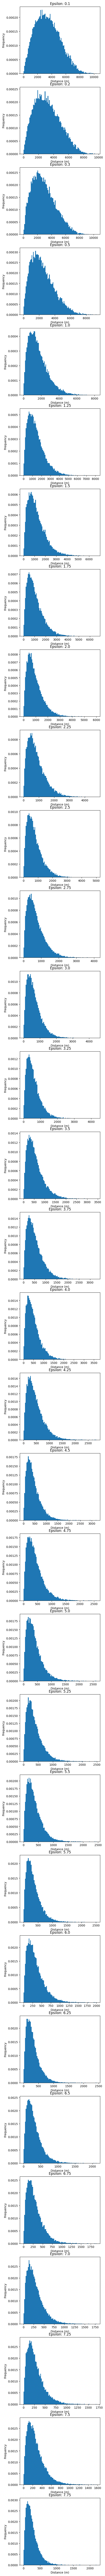

In [92]:
from geopy.distance import geodesic
from tqdm import notebook as vis
eps = [0.1, 0.2, 0.3, 0.5] + np.arange(1, 8, 0.25).tolist()

# We will create a figure for each epsilon value
fig, ax = plt.subplots(len(eps), 1, figsize=(5, 5*len(eps)))

for epsilon in vis.tqdm(eps,desc="Epsilon"):
    distances = []
    all_locs = queries[['lat', 'lon']].values
    for loc in vis.tqdm(all_locs,desc="Locations"):
        #print("a")
        obfuscated_loc = get_obfuscated_location(loc, epsilon)
        distances.append(geodesic(loc, obfuscated_loc).meters)
    ax[eps.index(epsilon)].hist(distances, bins=100, density=True)
    ax[eps.index(epsilon)].set_title(f"Epsilon: {epsilon}")
    ax[eps.index(epsilon)].set_xlabel("Distance (m)")
    ax[eps.index(epsilon)].set_ylabel("Frequency")
plt.show()

Consider that the adversary’s side information is that Alice is equally likely in either of two locations x and x′ ,i.e.,π(x) = π(x′) = 0.5. After observing z, the adversary has to decide between x and x ′. We refer to this adversary as the decision adversary. Assume, with- out loss of generality, that f (z|x) ≥ f (z|x′), and thus the optimal decision in terms of minimizing the adversary’s probability of error is deciding that Alice’s location is x. In this case, the adversary’s probability of error is:

![decisionAdversary](./decision-adversary.png)

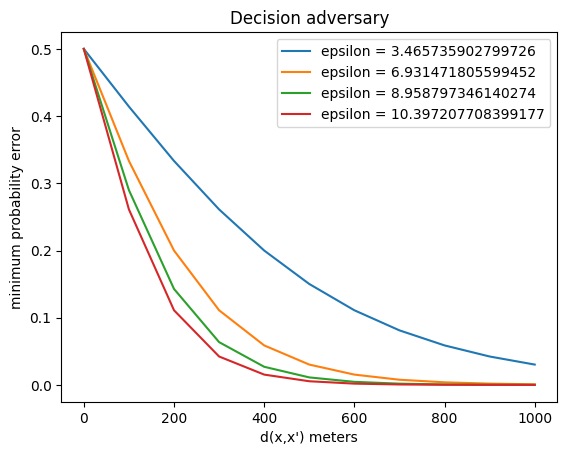

In [93]:
dists = []
ls = ls = [np.log(2), np.log(4), np.log(6), np.log(8)]
r = 0.2 #km
dists = np.linspace(0,1,11) # d(x,x') in meters

fig=plt.figure()
for l in ls:
    epsilon=l/r
    min_prob_errors = []
    for d in dists:
        err=1/(1+np.exp(epsilon*d))
        min_prob_errors.append(err)
        
    plt.plot(dists*1000,min_prob_errors,label='epsilon = '+str(epsilon))
    
    plt.xlabel('d(x,x\') meters')
    plt.ylabel('minimum probability error')
plt.title('Decision adversary')
plt.legend()
plt.show()
plt.close()
       